In [32]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, action_dim)

        self.max_action = max_action

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


class TD3(object):
    def __init__(
            self,
            state_dim,
            action_dim,
            max_action,
            discount=0.99,
            tau=0.005,
            policy_noise=0.2,
            noise_clip=0.5,
            policy_freq=2
    ):

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq

        self.total_it = 0

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1

        # Sample replay buffer
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        with torch.no_grad():
            # Select action according to policy and add clipped noise
            noise = (
                    torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)

            next_action = (
                    self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)

            # Compute the target Q value
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + not_done * self.discount * target_Q

        # Get current Q estimates
        current_Q1, current_Q2 = self.critic(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % self.policy_freq == 0:

            # Compute actor losse
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()

            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")

        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")

    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target = copy.deepcopy(self.actor)


In [33]:
import numpy as np
import torch


class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)

In [34]:
# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env, seed, eval_episodes=10):
	eval_env = env
	eval_env.reset(seed=seed
    )

	avg_reward = 0.
	for _ in range(eval_episodes):
		state, done = eval_env.reset(), False
		while not done:
			action = policy.select_action(np.array(state))
			state, reward, done, _ = eval_env.step(action)
			avg_reward += reward

	avg_reward /= eval_episodes

	print("---------------------------------------")
	print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
	print("---------------------------------------")
	return avg_reward

In [35]:
import gym
import numpy as np
import math

# Define the custom Gym environment for the mass-spring-damper system
class MassSpringDamperEnv(gym.Env):
    def __init__(self):
        super(MassSpringDamperEnv, self).__init__()

        # System parameters
        self.m = 1.0  # Mass (kg)
        self.k = 1.0  # Spring constant (N/m)
        self.c = 0.1  # Damping coefficient (N*s/m)

        # Simulation parameters
        self.dt = 0.01  # Time step (s)
        self.max_steps = 1000  # Maximum simulation steps
        self.current_step = 0

        # State and action spaces
        self.action_space = gym.spaces.Box(low=-100.0, high=100.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(2,))

        # Initial state
        self.state = None

    def reset(self, seed=None, return_info=False, options=None):
        # Reset the environment to an initial state
        self.state = np.array([10.0, 0.0])  # Initial position and velocity
        self.current_step = 0
        return self.state

    def step(self, action):
        # Apply control action and simulate one time step using Euler integration
        force = action[0]
        position, velocity = self.state

        acceleration = (force - self.c * velocity - self.k * position) / self.m
        velocity += acceleration * self.dt
        position += velocity * self.dt

        self.state = np.array([position, velocity])
        self.current_step += 1

        # Calculate the reward (e.g., minimize position error)
        reward = -abs(position)  # Negative position as the reward (minimize position error)

        # Check if the episode is done
        done = self.current_step >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode='human'):
        pass

    def close(self):
        pass

# Create the custom mass-spring-damper environment
env = MassSpringDamperEnv()

In [36]:
import numpy as np
import torch
import gym
import argparse
import os

# Define constants
DEFAULT_POLICY = "TD3"
DEFAULT_ENV = "MBK"
DEFAULT_SEED = 0
DEFAULT_START_TIMESTEPS = int(25e3)
DEFAULT_EVAL_FREQ = int(5e3)
DEFAULT_MAX_TIMESTEPS = int(1e5)
DEFAULT_EXPL_NOISE = 0.1
DEFAULT_BATCH_SIZE = 256
DEFAULT_DISCOUNT = 0.99
DEFAULT_TAU = 0.005
DEFAULT_POLICY_NOISE = 0.2
DEFAULT_NOISE_CLIP = 0.5
DEFAULT_POLICY_FREQ = 2

file_name = f"{DEFAULT_POLICY}_{DEFAULT_ENV}_{DEFAULT_SEED}"
print("---------------------------------------")
print(f"Policy: {DEFAULT_POLICY}, Env: {DEFAULT_ENV}, Seed: {DEFAULT_SEED}")
print("---------------------------------------")

if not os.path.exists("./results"):
    os.makedirs("./results")

if not os.path.exists("./models"):
    os.makedirs("./models")
    
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

kwargs = {"state_dim": state_dim, "action_dim": action_dim, "max_action": max_action, "discount": DEFAULT_DISCOUNT,
          "tau": DEFAULT_TAU, "policy_noise": DEFAULT_POLICY_NOISE * max_action,
          "noise_clip": DEFAULT_NOISE_CLIP * max_action, "policy_freq": DEFAULT_POLICY_FREQ} 
policy = TD3(**kwargs)

replay_buffer = ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy, env, DEFAULT_SEED)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0



---------------------------------------
Policy: TD3, Env: MBK, Seed: 0
---------------------------------------
---------------------------------------
Evaluation over 10 episodes: -99957.222
---------------------------------------


In [37]:
for t in range(int(DEFAULT_MAX_TIMESTEPS)):
    
    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < DEFAULT_START_TIMESTEPS:
        action = env.action_space.sample()
    else:
        action = (
            policy.select_action(np.array(state))
            + np.random.normal(0, max_action * DEFAULT_EXPL_NOISE, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done, _ = env.step(action) 
    done_bool = float(done) if episode_timesteps < env.max_steps else 0

    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    # Train agent after collecting sufficient data
    if t >= DEFAULT_START_TIMESTEPS:
        policy.train(replay_buffer, DEFAULT_BATCH_SIZE)

    if done: 
        # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        # Reset environment
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % DEFAULT_EVAL_FREQ == 0:
        evaluations.append(eval_policy(policy, env, DEFAULT_SEED))
        np.save(f"./results/{file_name}", evaluations)
        policy.save(f"./models/{file_name}")

Total T: 1000 Episode Num: 1 Episode T: 1000 Reward: -12888.186
Total T: 2000 Episode Num: 2 Episode T: 1000 Reward: -7960.119
Total T: 3000 Episode Num: 3 Episode T: 1000 Reward: -9288.500
Total T: 4000 Episode Num: 4 Episode T: 1000 Reward: -4930.701
Total T: 5000 Episode Num: 5 Episode T: 1000 Reward: -11300.020
---------------------------------------
Evaluation over 10 episodes: -99957.222
---------------------------------------
Total T: 5001 Episode Num: 6 Episode T: 1 Reward: -163.335
Total T: 6001 Episode Num: 7 Episode T: 1000 Reward: -5426.728
Total T: 7001 Episode Num: 8 Episode T: 1000 Reward: -6842.111
Total T: 8001 Episode Num: 9 Episode T: 1000 Reward: -4692.523
Total T: 9001 Episode Num: 10 Episode T: 1000 Reward: -7045.824
---------------------------------------
Evaluation over 10 episodes: -99957.222
---------------------------------------
Total T: 10001 Episode Num: 11 Episode T: 1000 Reward: -6422.373
Total T: 11001 Episode Num: 12 Episode T: 1000 Reward: -7987.461
T

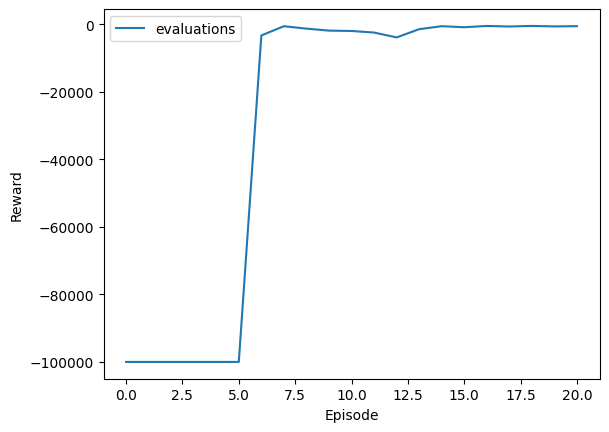

In [38]:
import matplotlib.pyplot as plt

evaluations = np.load(f"./results/{file_name}.npy")

plt.plot(evaluations, label="evaluations")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

In [39]:
# show results for one episode with policy
state, done = env.reset(), False
episode_reward = 0
state_array = []
action_array = []
while not done:
    action = policy.select_action(np.array(state))
    state, reward, done, _ = env.step(action)
    state_array.append(state)
    action_array.append(action)
    episode_reward += reward
    env.render()
print(f"Episode Reward: {episode_reward:.3f}")

Episode Reward: -595.543


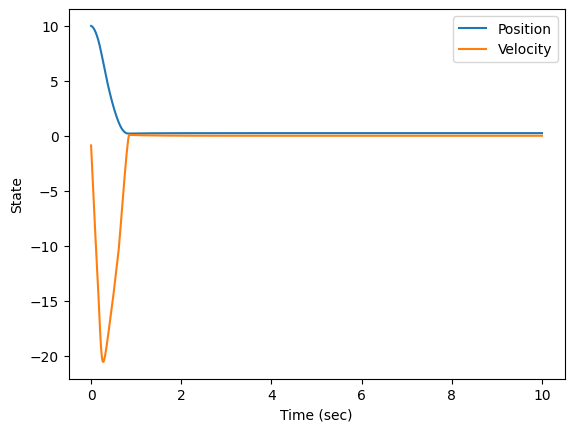

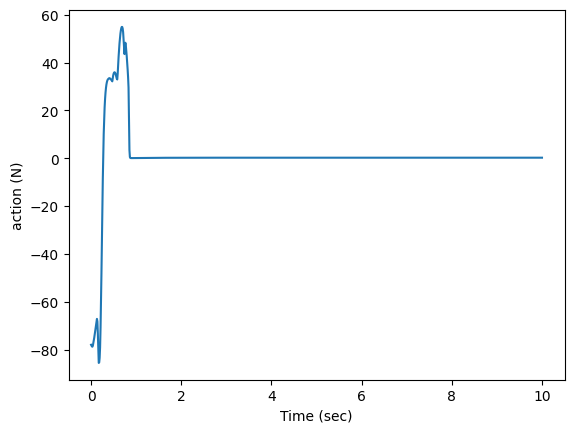

In [44]:
plt.plot(np.linspace(0, 10, num=len(state_array)),state_array)
plt.xlabel("Time (sec)")
plt.ylabel("State")
plt.legend(["Position", "Velocity"])
plt.show()

plt.plot(np.linspace(0, 10, num=len(state_array)), action_array)
plt.xlabel("Time (sec)")
plt.ylabel("action (N)")
plt.show()